In [1]:
#Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from statistics import mean
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller

%matplotlib notebook

In [2]:
#Reading data from excel file
fam_incidents = pd.read_excel("Resources/Data_Tables_Family_Incidents_Visualisation_Year_Ending_September_2022.xlsx","Table 02")
fam_incidents2 = pd.read_excel("Resources/Data_Tables_Family_Incidents_Visualisation_Year_Ending_September_2022.xlsx","Table 01")

# 1. Number of Family Incidents within the period from Jan-18 to Dec-22

## 1.1 Cleaning Family Incidents data

In [3]:
#Create a new column to combine month and year
fam_incidents["MonYr"] = fam_incidents["Month"]+"-"+fam_incidents["Year"].map(str)

#Create a new column to convert above column into Date-Time format for sorting purpose
fam_incidents["MonYr2"]=pd.to_datetime(fam_incidents["MonYr"])

#Create a new column for labeling purpose
fam_incidents["MonYr3"]=fam_incidents["Month"].str[0:3]+"-"+fam_incidents["Year"].astype(str).str[2:4]

#Sort values by Month and year
sorted_fam = fam_incidents.sort_values(by="MonYr2")

#Create new column to store Pre covid or Post covid 
sorted_fam['Group'] = np.where(((sorted_fam['Year'] == 2018) |(sorted_fam['Year'] == 2019)) , 'Pre Covid-19', \
                               'Post Covid-19')
sorted_fam.head()


,Year,Year ending,Quarter,Month,Family Incident Count,MonYr,MonYr2,MonYr3,Group
52,2018,September,Jan-Mar,January,7125,January-2018,2018-01-01,Jan-18,Pre Covid-19
51,2018,September,Jan-Mar,February,6354,February-2018,2018-02-01,Feb-18,Pre Covid-19
53,2018,September,Jan-Mar,March,6698,March-2018,2018-03-01,Mar-18,Pre Covid-19
48,2018,September,Apr-Jun,April,5892,April-2018,2018-04-01,Apr-18,Pre Covid-19
50,2018,September,Apr-Jun,May,6161,May-2018,2018-05-01,May-18,Pre Covid-19


## 1.2 Analysing Family Incidents data

### 1.2.1 Family Incidents Analysis - Part 1 - Depicting Overall Trend

<IPython.core.display.Javascript object>


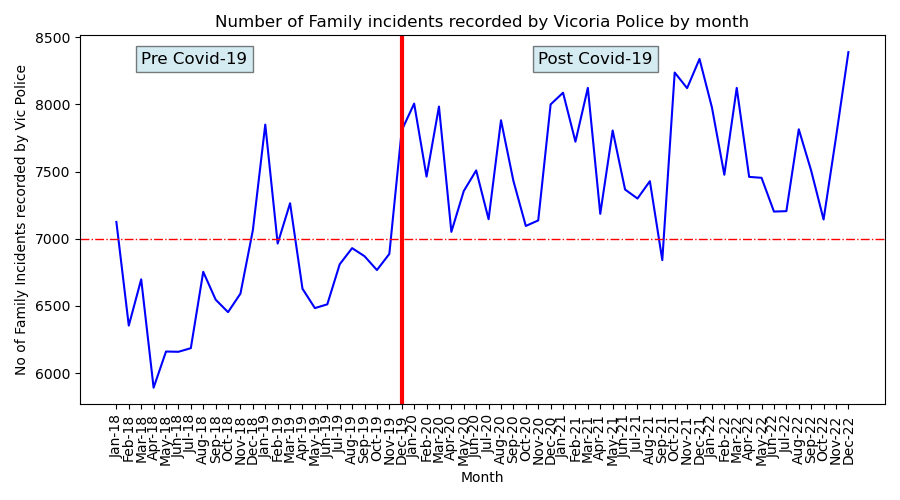

In [4]:
#Create a line graph to show the trend of Number of Family Incidents over the period from 2018 to 2022
plt_1 = plt.figure(figsize=(9,5))
plt.text(2, 8300, 'Pre Covid-19', fontsize = 12, bbox = dict(facecolor = 'lightblue', alpha = 0.5))
plt.text(34, 8300, 'Post Covid-19', fontsize = 12, bbox = dict(facecolor = 'lightblue', alpha = 0.5))
plt.plot(sorted_fam["MonYr3"],sorted_fam["Family Incident Count"], color = "blue", label = "Number of Family Incidents")
plt.title("Number of Family incidents recorded by Vicoria Police by month")
plt.xlabel("Month")
plt.ylabel("No of Family Incidents recorded by Vic Police")
plt.xticks(rotation=90)
#plt.grid()
plt.tight_layout()
plt.axhline(7000,color='r', linestyle='dashdot', linewidth=1, label="No of Fam incidents = 7,000")
plt.axvline(23,color='r', linestyle='solid', linewidth=3, label="Pre-covid")

plt.show()

In [5]:
sorted_fam["Family Incident Count"].max()

8388

The Figure 1 indicates that there is an upward trend of Family incidents in Victoria over the period from Jan-18 to Dec-22. During the Pre Covid-19 period, the number of family incidents falls below the line of 7,000 in majority of months except few months namely Jan-18, Dec-18, Jan-19, Mar-19 and Dec-19. Within the post Covid-19 period, only one month shows a less than 7,000 record of family incidents and all other months recorded above 7,000 family incidents with the highest of 8,388 in Dec-22. By looking at the overall upward trend, it is possible to see that the increase in number of family incidents is deteriorating after 2020. That means eventhough the number of family incidents showed an upward trend, the growth of increase has been slowering after 2020. Also at a glance a seasonal trend can be seen from the time series. To explore more about any seasonal trend appearing in Figure 1, it is possible to plot five differnt line graphs for each year.

### 1.2.2 Family Incidents Analysis - Part 2 - Depicting Seasonal Pattern 

<IPython.core.display.Javascript object>


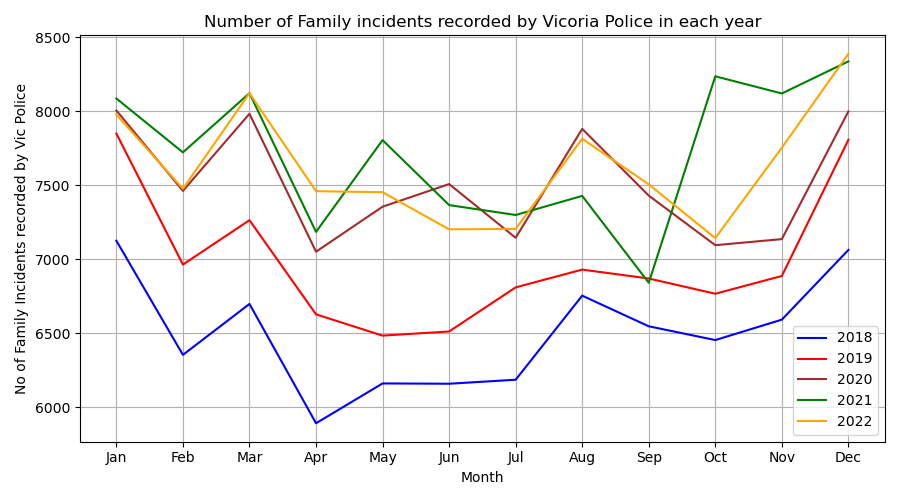

In [6]:
#Create lists to store year
Unique_year=sorted_fam["Year"].unique()
Monthly_data=[]

#Store each year data as seperate lists
for y in Unique_year:
    fam_by_year = sorted_fam.loc[sorted_fam["Year"]== y,:].copy()
    Monthly_data.append(fam_by_year["Family Incident Count"])
    
#Plot line graphs for each year
#Define X-axis
x_axis = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
plt_2 = plt.figure(figsize=(9,5))
plt.plot(x_axis, Monthly_data[0], color = "blue", label = "2018")
plt.plot(x_axis, Monthly_data[1], color = "red", label = "2019")
plt.plot(x_axis, Monthly_data[2], color = "brown", label = "2020")
plt.plot(x_axis, Monthly_data[3], color = "green", label = "2021")
plt.plot(x_axis, Monthly_data[4], color = "orange", label = "2022")
plt.title("Number of Family incidents recorded by Vicoria Police in each year")
plt.xlabel("Month")
plt.ylabel("No of Family Incidents recorded by Vic Police")
plt.grid()
plt.tight_layout()
plt.legend()

plt.show()


The above figure 2 exhibits the number of family incidents by month in each year from 2018 to 2022. It is clear from the graph that every year from 2018 to 2020, the number of family incidents has been increased in every month when compared to the same month in previous year. After 2020, this trend was changed. There are some months after January 2021, the recorded family incidents were less than that record in same month of previous year. For example, the number of family incidents in Aug-2021 is considerably less than that record in Aug-2020. 
Also the gaps between 2018 & 2019 and 2019 & 2020 are clearly higher when compared to the gaps between 2020 & 2021 and 2021 & 2022. 

### 1.2.3 Family Incidents Analysis - Part 3 - Performing two sided t-test for two populations

The aim of this section is to perform two sided T-test to find out if the monthly average of family incidents within post covid period is significantly different from the monthly average of family incidents in pre coivd time period.

Because our time series clearly shows an upward trend, we have to remove the trend before performing T-test in order to make the assumption that the data is independent. 

Steps followed in this section:
1. Define the two populations.
2. Detrend the time series data fitting a linear regression model.
3. Apply Augmented Dickey Fuller Test to find out if the detrended time series has a stochastic trend.
   (Based on ADF test, we failed to reject null hypothesis - hence assumed that time series is not stationary)
4. Then we used first differncing method to remove the stochastic trend. 
5. Apply Augmented Dickey Fuller Test again to find out if the detrended and differenced time series is stationary.
   (Based on ADF test, there was evidence to reject null hypothesis - hence assumed that the time series is staionary)
6. Check if the transformed data supports normality assumption.
7. Perform two sided T-test.

#### 1.2.3.1 Define the two population

Within this analysis we consider the period from January-2018 to December-2019 as Pre Covid-19 period and the period from January-2020 to December-2022 as Post Covid-19 period.
In the original data sets, we have 24 values (No of Family incidents in 24 months) in Pre Covid-19 period and 36 values (No of Family incidents in 36 months) in Post Covid-19 period.
Therefore the sample size of original pre covid data set is 24 and the sample size of original post covid data set is 36.

In [7]:
#Create two populations - Divide data into two sets - Pre Covid-19 and Post Covid-19

#Create a new Dataframe contains only Pre Covid-19 time data
pre_covid = sorted_fam.loc[sorted_fam["Group"]=="Pre Covid-19",:].copy()
pre_covid_df = pre_covid.rename(columns={"MonYr3":"Month-Yr"})

#Create a new Dataframe contains only Post Covid-19 time data
post_covid = sorted_fam.loc[sorted_fam["Group"]=="Post Covid-19",:].copy()
post_covid_df = post_covid.rename(columns={"MonYr3":"Month-Yr"})

#### 1.2.3.2 Remove Trend Component from the time series - Applying Linear regression

<IPython.core.display.Javascript object>


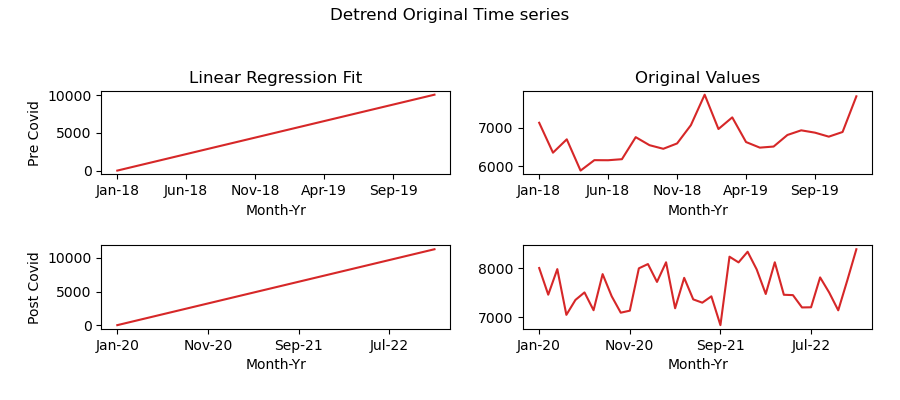

In [8]:
#Remove Trend

#Pre Covid data series
pre_original=pre_covid_df.set_index("Month-Yr")["Family Incident Count"]
least_squares1 = OLS(pre_original.values, list(range(pre_original.shape[0])))
result1 = least_squares1.fit()
fit1 = pd.Series(result1.predict(list(range(pre_original.shape[0]))), index = pre_original.index)
pre_detrended = pre_original - fit1

#Post Covid data series
post_original=post_covid_df.set_index("Month-Yr")["Family Incident Count"]
least_squares2 = OLS(post_original.values, list(range(post_original.shape[0])))
result2 = least_squares2.fit()
fit2 = pd.Series(result2.predict(list(range(post_original.shape[0]))), index = post_original.index)
post_detrended = post_original - fit2

#Create subplots for Original Time series and Regression fit
plt.figure(figsize=(9,4))

ax1 = plt.subplot(2,2,1)
fit1.plot(color="tab:red", title="Linear Regression Fit", ax=ax1, ylabel="Pre Covid")
ax2 = plt.subplot(2,2,2)
pre_original.plot(color="tab:red", title="Original Values", ax=ax2)
ax3 = plt.subplot(2,2,3)
fit2.plot(color="tab:red", ax=ax3, ylabel="Post Covid")
ax4 = plt.subplot(2,2,4)
post_original.plot(color="tab:red", ax=ax4)
plt.suptitle("Detrend Original Time series")
plt.tight_layout(pad=2.0)
plt.show()

#### 1.2.3.3 Apply Augmented Dickey Fuller Test to find out if the detrended time series has a stochastic trend

Two seperate ADF tests were done for each time series, pre Covid and post Covid. 

The hypotheses for the tests:

    The null hypothesis: Time series is not stationary.
    
    The alternate hypothesis:  Time series is stationary.

In [9]:
#applying the dicky-fuller test for detrended data

dftest_pre_detrended = adfuller(pre_detrended.values, autolag = 'AIC')
dftest_post_detrended = adfuller(post_detrended.values, autolag = 'AIC')

adf_test1 = dftest_pre_detrended[0],dftest_post_detrended[0]
p_val_test1 = dftest_pre_detrended[1],dftest_post_detrended[1]
lags_test1 = dftest_pre_detrended[2],dftest_post_detrended[2]
obs_test1 = dftest_pre_detrended[3],dftest_post_detrended[3]
cv_1_test1 = dftest_pre_detrended[4]["1%"],dftest_post_detrended[4]["1%"]
cv_5_test1 = dftest_pre_detrended[4]["5%"],dftest_post_detrended[4]["5%"]
cv_10_test1 = dftest_pre_detrended[4]["10%"],dftest_post_detrended[4]["10%"]

ADF_test1_summary = pd.DataFrame({"Group": ["Pre Covid-19 Data", "Post Covid-19 Data"],
                            "ADF": adf_test1,
                            "P-Value" : p_val_test1,
                            "Num of Lags": lags_test1,
                            "Num of Observations used":obs_test1,
                            "CV at 1% level": cv_1_test1,
                            "CV at 5% level": cv_5_test1,
                            "CV at 10% level": cv_10_test1})

ADF_test1_summary

,Group,ADF,P-Value,Num of Lags,Num of Observations used,CV at 1% level,CV at 5% level,CV at 10% level
0,Pre Covid-19 Data,-1.568301,0.499495,0,23,-3.752928,-2.998500,-2.638967
1,Post Covid-19 Data,1.335091,0.996798,10,25,-3.723863,-2.986489,-2.632800


Since the P-value is greater than 0.05 in above tests for both samples, we fail to reject null hypothesis so we have to accept that there can be a stochastic trend in both time series. 

Then we applied first differencing method to detrended data.

#### 1.2.3.4 Eliminating stochastic trend - First Differencing method

<IPython.core.display.Javascript object>


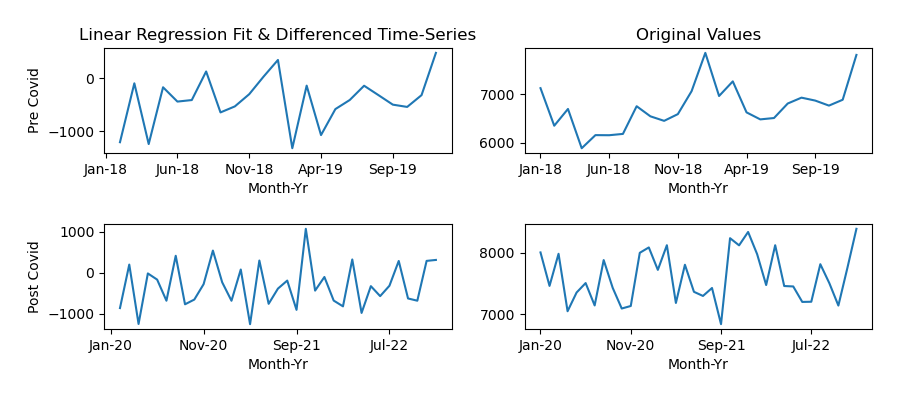

In [10]:
#Remove stochastic effect

#Pre Covid data series
pre_detrended_diff = pre_detrended - pre_detrended.shift()

#Post Covid data series
post_detrended_diff = post_detrended - post_detrended.shift()

#Create subplots for Original Time series and Differenced Regression fit
plt.figure(figsize=(9,4))

ax1 = plt.subplot(2,2,1)
pre_detrended_diff.plot(color="tab:blue", title="Linear Regression Fit & Differenced Time-Series", ax=ax1, ylabel="Pre Covid")
ax2 = plt.subplot(2,2,2)
pre_original.plot(color="tab:blue", title="Original Values", ax=ax2)
ax3 = plt.subplot(2,2,3)
post_detrended_diff.plot(color="tab:blue", ax=ax3, ylabel="Post Covid")
ax4 = plt.subplot(2,2,4)
post_original.plot(color="tab:blue", ax=ax4)

plt.tight_layout(pad=2.0)
plt.show()

#### 1.2.3.5 Apply Augmented Dickey Fuller Test to find out if the detrended and differenced time series is stationary

In order to find out if the time series transformed in above steps two seperate ADF tests were done again for each transformed time series, pre Covid and post Covid. 

The hypotheses for the tests:

    The null hypothesis: Time series is not stationary.
    
    The alternate hypothesis:  Time series is stationary.


In [11]:
#applying the dicky-fuller test for pre covid data

dftest_pre = adfuller(pre_detrended_diff.dropna().values, autolag = 'AIC')
dftest_post = adfuller(post_detrended_diff.dropna().values, autolag = 'AIC')

adf_test2 = dftest_pre[0],dftest_post[0]
p_val_test2 = dftest_pre[1],dftest_post[1]
lags_test2 = dftest_pre[2],dftest_post[2]
obs_test2 = dftest_pre[3],dftest_post[3]
cv_1_test2 = dftest_pre[4]["1%"],dftest_post[4]["1%"]
cv_5_test2 = dftest_pre[4]["5%"],dftest_post[4]["5%"]
cv_10_test2 = dftest_pre[4]["10%"],dftest_post[4]["10%"]

ADF_test2_summary = pd.DataFrame({"Group": ["Pre Covid-19 Data", "Post Covid-19 Data"],
                            "ADF": adf_test2,
                            "P-Value" : p_val_test2,
                            "Num of Lags": lags_test2,
                            "Num of Observations used":obs_test2,
                            "CV at 1% level": cv_1_test2,
                            "CV at 5% level": cv_5_test2,
                            "CV at 10% level": cv_10_test2})

ADF_test2_summary

,Group,ADF,P-Value,Num of Lags,Num of Observations used,CV at 1% level,CV at 5% level,CV at 10% level
0,Pre Covid-19 Data,-6.128730,8.503470e-08,0,22,-3.769733,-3.005426,-2.642501
1,Post Covid-19 Data,-3.639152,5.055155e-03,7,27,-3.699608,-2.976430,-2.627601


In both groups of data, the p-value is less than the significance level of 0.05 and ADF is less than all critical values. Hence there is evidence to reject the null hypothesis and consider those Linear Regression Fit & Differenced Time-Series for both groups pre covid and post covid are stationary.

Our next step is to find if these transformed datasets support the normality assumption. We have generated two box plots to get an idea about the distribution.


#### 1.2.3.6 Check if data supports normality assumption

<IPython.core.display.Javascript object>


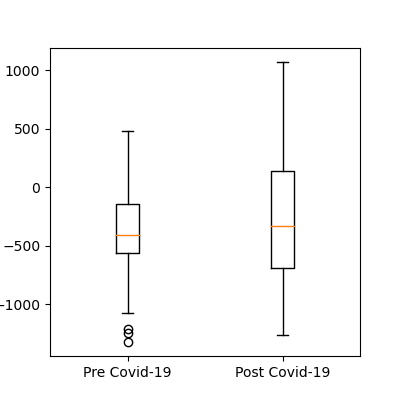

In [12]:
plt.figure(figsize=(4,4))
plt.boxplot((pre_detrended_diff.dropna().values,post_detrended_diff.dropna().values), labels = ("Pre Covid-19", \
                                                                                                "Post Covid-19"))
plt.show()

based on above box plot, the distribution of transformed data set for post covid-19 period looks like normaly distributed. The box plot for pre covid-19 period displays little skewness. However, given that the pre covid distribution is not too far from the normal distribution shape and the purpose of this assigment is not targeting a deep look in statistical theory, we assume that both transformed data sets are normaly distributed.

#### 1.2.3.7 Perform two sided independent t-test

The below independent t-test will compare the means of 2 independent populations - Pre Covid-19 period and Post Covid-19 period

Assumptions:

    Data is normally distributed
    Data is independent

Null Hypothesis: Mean of the two population is same

Alternative Hypothesis: Mean of post covid period is significantly different from mean of pre covid period


<IPython.core.display.Javascript object>


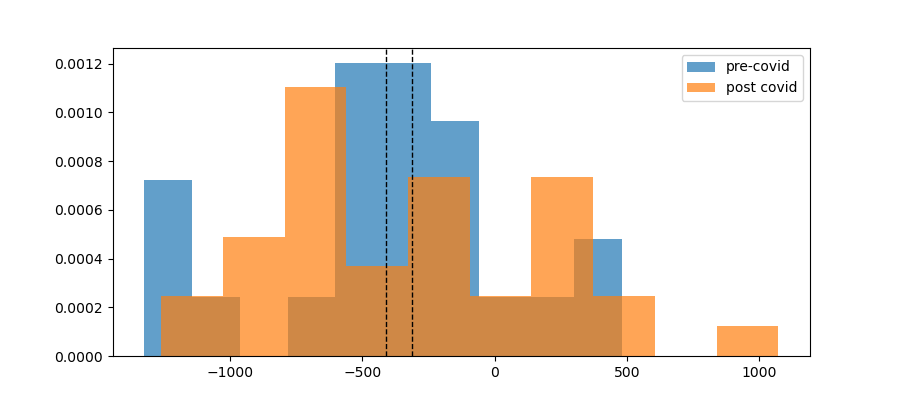

In [13]:
#draw a histogram
plt.figure(figsize=(9,4))
plt.hist(pre_detrended_diff.dropna().values, 10, density=True, alpha=0.7, label="pre-covid")
plt.hist(post_detrended_diff.dropna().values, 10, density=True, alpha=0.7, label="post covid")
plt.axvline(pre_detrended_diff.dropna().values.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(post_detrended_diff.dropna().values.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()
plt.show()

In [14]:
#Calculate t- statistic 
st.ttest_ind(pre_detrended_diff.dropna().values,post_detrended_diff.dropna().values, alternative = 'two-sided',\
             equal_var=False)

Ttest_indResult(statistic=-0.7189932821370008, pvalue=0.47538580239223827)

The P-value of the above t-test is greater than 0.05. Therefore we fail to reject the null hypothesis that the mean of the two population is same.

## 1.3 Conclusion on Family Incidents Analysis

Based on the independent T-test perfromed above, we can conclude that the monthly average of family incidents in post covid period is not statistically significatly different from the monthly average of family incidents in pre covid period in Victoria. 